# Scarico i dati

In [49]:
%%bash
# leggo la data di oggi
oggi=$(echo $(date +'%d %m %Y') | sed 's/ /%2F/g')
# Prima scarico i dati
# le segnalazioni aperte
curl -sL 'http://www.rapspaservizi.it/develop1/bastaundito/bastaundito_dev/mappa' -H 'Connection: keep-alive' \
-H 'Cache-Control: max-age=0' -H 'Origin: http://www.rapspaservizi.it' -H 'Upgrade-Insecure-Requests: 1' \
-H 'Content-Type: application/x-www-form-urlencoded' \
-H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.40 Safari/537.36' \
-H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' \
-H 'Referer: http://www.rapspaservizi.it/develop1/bastaundito/bastaundito_dev/mappa' -H 'Accept-Encoding: gzip, deflate' \
-H 'Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7' \
--data 'giorno_dal=01%2F01%2F2018&giorno_al='"$oggi"'&attivita_id=31&circoscrizione_id=T&stato=A' >./aperte
# le segnalazioni aperte
curl -sL 'http://www.rapspaservizi.it/develop1/bastaundito/bastaundito_dev/mappa' -H 'Connection: keep-alive' \
-H 'Cache-Control: max-age=0' -H 'Origin: http://www.rapspaservizi.it' -H 'Upgrade-Insecure-Requests: 1' \
-H 'Content-Type: application/x-www-form-urlencoded' \
-H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.40 Safari/537.36' \
-H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' \
-H 'Referer: http://www.rapspaservizi.it/develop1/bastaundito/bastaundito_dev/mappa' -H 'Accept-Encoding: gzip, deflate' \
-H 'Accept-Language: it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7' \
--data 'giorno_dal=01%2F01%2F2018&giorno_al='"$oggi"'&attivita_id=31&circoscrizione_id=T&stato=C' >./chiuse

## Contenuto del file sorgente

Qui sotto un estratto del file sorgente, per mostrare come è fatto.

In [50]:
!cat aperte |  awk 'f{ if (/marker_2 =/){printf "%s", buf; f=0; buf=""} else buf = buf $0 ORS}; /marker_1/{f=1}'

			
			marker_1.set("content", "<h4>17/05/2018  20:23:28</h4><p>VIA PACINI GIOVANNI, 86</p><p><img style=\"height:400px\" src=\"http://www.rapspaservizi.it/develop1/images/segnalazioni/segnalazione_25250.jpg\" alt=\"Foto non disponibile\"></p>");
			
			google.maps.event.addListener(marker_1, "click", function(event) {
				iw_map.setContent(this.get("content"));
				iw_map.open(map, this);
			
			});
			
			var myLatlng = new google.maps.LatLng(38.11658060,13.33686580);
			
				var marker_icon = {
					url: "http://www.rapspaservizi.it/develop1/images/sito/cerchietto_rosso.png"};
				
			var markerOptions = {
				map: map,
				position: myLatlng,
				icon: marker_icon		
			};


## Estraggo le informazioni su ogni segnalazione

In [51]:
%%bash
# Le info anagrafiche su ogni "pallino" (le coordinate sono in un blocco diverso da quello anagrafico)
## creo riga di intestazione
echo "data,indirizzo,foto,stato" >./dati.csv
## estraggo info su segnalazioni aperte
<aperte grep -P 'marker_[0-9]+.set.*' | \
perl -pe  's|(marker_)([0-9]+)(.*?)(<h[0-9]>)(.*?)(<.h[0-9]>)(<p>)(.*?)(<.p>)(.*?)(src=.")(.*?)(.")(.*)$|$5#$8#$12|g' | \
grep -v 'marker' | csvformat -d "#" | sed -e 's/$/,aperta/g' | sed -r 's/^\s+//' >>./dati.csv
## estraggo info su segnalazioni aperte chiuse
<chiuse grep -P 'marker_[0-9]+.set.*' | \
perl -pe  's|(marker_)([0-9]+)(.*?)(<h[0-9]>)(.*?)(<.h[0-9]>)(<p>)(.*?)(<.p>)(.*?)(src=.")(.*?)(.")(.*)$|$5#$8#$12|g' | \
grep -v 'marker' | csvformat -d "#" | sed -e 's/$/,chiusa/g' | sed -r 's/^\s+//' >>./dati.csv

## Estraggo le coordinate di ogni segnalazione

In [52]:
%%bash
## info sulle coordinate
echo "latitude,longitude" >./coords.txt
<aperte grep -P 'google.maps.LatLng' | tail -n +3 | sed -r 's/^\s+//g' | perl -pe  's/^(.+?\()(.+?)(.;)/$2/g' >>coords.txt
<chiuse grep -P 'google.maps.LatLng' | tail -n +3 | sed -r 's/^\s+//g' | perl -pe  's/^(.+?\()(.+?)(.;)/$2/g' >>coords.txt
# metto insieme le info anagrafiche con quelle spaziali
paste -d , dati.csv coords.txt >./output.csv

## Metto insieme i dati estratti e creo output in CSV e GeoJSON

In [53]:
%%bash
# rimuovo i record che hanno 0 come coordinate e creo geojson
<output.csv csvgrep -c "latitude,longitude" -r '^.{0,1}0.{0,1}$' -i | csvjson --lat latitude --lon longitude >output.geojson

In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# import dei dati
dati=pd.read_csv('output.csv')
# aggiunta di una colonna con il formato in datetime
dati['datetime'] = dati.apply(lambda x: pd.to_datetime(x['data'], format='%d/%m/%Y %H:%M:%S', errors='coerce'), axis=1)
dati.head(3)

,data,indirizzo,foto,stato,latitude,longitude,datetime
0,17/05/2018 20:23:28,"VIA PACINI GIOVANNI, 86",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.119103,13.346448,2018-05-17 20:23:28
1,17/05/2018 14:17:51,"VIA RE ENZO,",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.116581,13.336866,2018-05-17 14:17:51
2,17/05/2018 11:44:21,"VIA ANTIGONE, 91",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.193372,13.311718,2018-05-17 11:44:21


In [56]:
# dati per mese
permese=dati['datetime'].groupby([dati.datetime.dt.month]).agg('count')
permese

datetime
1    225
2    207
3    290
4    319
5    180
Name: datetime, dtype: int64

In [57]:
# creo un geodataframe a partire dai dati importati
from shapely.geometry import Point
punti = [Point(xy) for xy in zip(dati.longitude, dati.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(dati, crs=crs, geometry=punti)
gdf.head(3)

,data,indirizzo,foto,stato,latitude,longitude,datetime,geometry
0,17/05/2018 20:23:28,"VIA PACINI GIOVANNI, 86",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.119103,13.346448,2018-05-17 20:23:28,POINT (13.3464476 38.1191032)
1,17/05/2018 14:17:51,"VIA RE ENZO,",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.116581,13.336866,2018-05-17 14:17:51,POINT (13.3368658 38.1165806)
2,17/05/2018 11:44:21,"VIA ANTIGONE, 91",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.193372,13.311718,2018-05-17 11:44:21,POINT (13.3117176 38.1933724)


# Scarico i dati sulle circoscrizioni di Palermo

In [58]:
%%bash
dataURL="https://opendata.comune.palermo.it/js/server/uploads/dataset/shp/_10012018112603.zip"
mkdir -p ./geodata
curl -sL "$dataURL" >./geodata/circoscrizioni.zip
cd ./geodata
unzip -qq circoscrizioni.zip

replace _22022013155256/Circoscrizioni.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [59]:
# importo i dati sulle circoscrizioni e imposto il sistema di coordinate
circoscrizioni=gpd.read_file('./geodata/_22022013155256/Circoscrizioni.shp')
circoscrizioni.crs = ({'init': 'epsg:3004'})
# converto le coordinate da Gauss Boaga a geografiche
circoscrizioni = circoscrizioni.to_crs({'init': 'epsg:4326'})
circoscrizioni

,CIR_ID,geometry
0,2,"POLYGON ((13.41356851785149 38.08625623922559,..."
1,3,"POLYGON ((13.34439726980255 38.08985235701616,..."
2,4,"POLYGON ((13.35416657280543 38.10883351603021,..."
3,1,"POLYGON ((13.35776047934581 38.12113824191273,..."
4,7,"POLYGON ((13.30465891822817 38.22086630274237,..."
5,8,"POLYGON ((13.34356883448918 38.14672675446521,..."
6,5,"POLYGON ((13.29811120729223 38.1375557011977, ..."
7,6,"POLYGON ((13.26239296736765 38.15954181207574,..."


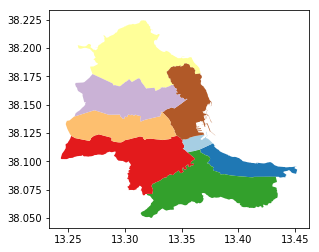

In [60]:
circoscrizioni.plot(column='CIR_ID', cmap='Paired', categorical=True);


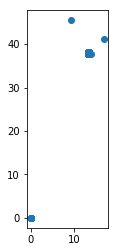

In [61]:
gdf.plot()

In [62]:
# tutti i punti che ricadono nelle circoscrizioni del comune. 
puntiCircoscrzioni=gpd.sjoin(gdf, circoscrizioni, op='within',how="inner")
# In output ho anche l'ID della circoscizione nella colonna `CIR_ID`
puntiCircoscrzioni.head(2)

,data,indirizzo,foto,stato,latitude,longitude,datetime,geometry,index_right,CIR_ID
0,17/05/2018 20:23:28,"VIA PACINI GIOVANNI, 86",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.119103,13.346448,2018-05-17 20:23:28,POINT (13.3464476 38.1191032),2,4
1,17/05/2018 14:17:51,"VIA RE ENZO,",http://www.rapspaservizi.it/develop1/images/se...,aperta,38.116581,13.336866,2018-05-17 14:17:51,POINT (13.3368658 38.1165806),2,4


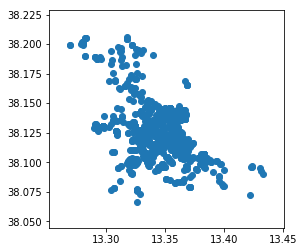

In [63]:
puntiCircoscrzioni.plot()

In [64]:
# conteggio il numero di segnalazioni per circoscizione
segnalazioniCircoscrizioni=puntiCircoscrzioni['CIR_ID'].groupby([puntiCircoscrzioni.CIR_ID]).agg('count').reset_index(name='conteggio')
segnalazioniCircoscrizioni

,CIR_ID,conteggio
0,1,165
1,2,75
2,3,125
3,4,241
4,5,164
5,6,57
6,7,63
7,8,282


In [65]:
# faccio il merge delle geometrie con il conteggio per circoscrizione
circoscrizioni=circoscrizioni.merge(segnalazioniCircoscrizioni, on='CIR_ID')
circoscrizioni

,CIR_ID,geometry,conteggio
0,2,"POLYGON ((13.41356851785149 38.08625623922559,...",75
1,3,"POLYGON ((13.34439726980255 38.08985235701616,...",125
2,4,"POLYGON ((13.35416657280543 38.10883351603021,...",241
3,1,"POLYGON ((13.35776047934581 38.12113824191273,...",165
4,7,"POLYGON ((13.30465891822817 38.22086630274237,...",63
5,8,"POLYGON ((13.34356883448918 38.14672675446521,...",282
6,5,"POLYGON ((13.29811120729223 38.1375557011977, ...",164
7,6,"POLYGON ((13.26239296736765 38.15954181207574,...",57


In [66]:
# area circoscrizioni in metri quadrati
circoscrizioni['area']=circoscrizioni['geometry'].to_crs({'init': 'epsg:3004'}).area
# numero di incidenti per kilometro quadrato
circoscrizioni['conteggioN']=(circoscrizioni['conteggio'])/(circoscrizioni['geometry'].to_crs({'init': 'epsg:3004'}).area)*1000000
circoscrizioni

,CIR_ID,geometry,conteggio,area,conteggioN
0,2,"POLYGON ((13.41356851785149 38.08625623922559,...",75,1.034282e+07,7.251405
1,3,"POLYGON ((13.34439726980255 38.08985235701616,...",125,3.096907e+07,4.036285
2,4,"POLYGON ((13.35416657280543 38.10883351603021,...",241,2.817382e+07,8.554040
3,1,"POLYGON ((13.35776047934581 38.12113824191273,...",165,2.485935e+06,66.373428
4,7,"POLYGON ((13.30465891822817 38.22086630274237,...",63,3.038867e+07,2.073141
5,8,"POLYGON ((13.34356883448918 38.14672675446521,...",282,1.627340e+07,17.328892
6,5,"POLYGON ((13.29811120729223 38.1375557011977, ...",164,1.831647e+07,8.953690
7,6,"POLYGON ((13.26239296736765 38.15954181207574,...",57,2.321635e+07,2.455166


In [67]:
# aggiungo mappa di base, vedi https://gist.github.com/jorisvandenbossche/2b9ce4856b403623e1ca6760112cab87
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

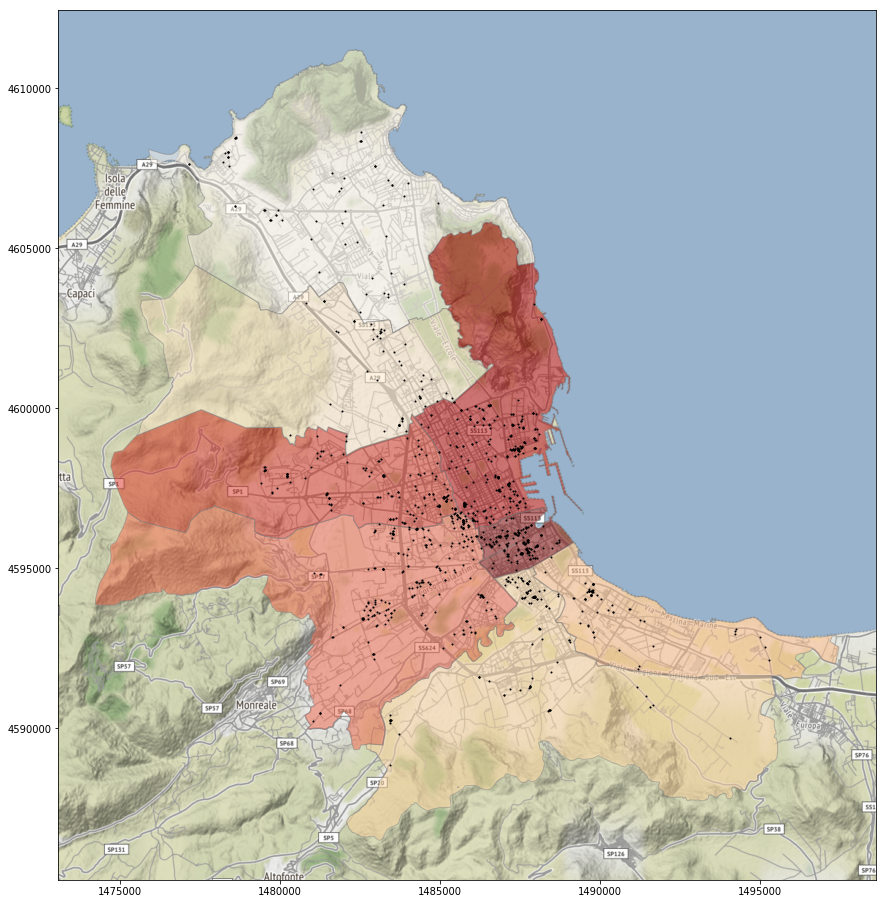

In [68]:
# converto sistema di coordinate in web mercatore, per sfruttare le mappe di base, che sono in 3857
circoscrizioniWm = circoscrizioni.to_crs(epsg=3857)
puntiCircoscrzioniWm = puntiCircoscrzioni.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_aspect('equal')
circoscrizioniWm.plot(ax=ax, column='conteggioN', scheme='QUANTILES', alpha=0.5, k=9, cmap=plt.cm.OrRd,edgecolor='grey');
puntiCircoscrzioniWm.plot(ax=ax, marker='o', color='black', markersize=1)
add_basemap(ax, zoom=13)
plt.show();